[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/Action_potentials_K_channel.ipynb)

If you are using `colab`, in a fresh runtime you need to run pip to install pymoose there. On the other hand, if you are running jupyter locally and have pymoose installed in that environment, skip the line below.

In [1]:
## Only required on colab!
# !pip install pymoose --quiet

# Action potentials and Hodgkin-Huxley model

Cytoplasm is not a very good conductor of electricity. As electric current propagates along a passive neuronal cable, the voltage keeps dropping with distance from source. Thus passive propagation is not a good strategy for sending signals along neurons in general.

In reality most neurons, when stimulated, generate sudden jumps in membrane potential. These are called spikes because of their shape in plots of membrane potential.

Alan Hodgkin and Andrew Huxley elucidated the mechanism of spike generation by conducting experiments on the giant axon of loligo (squid). They suggested that the behavior of the axon membrane can be modeled by adding to the parallel (passive) RC circuit $Na^{+}$ and $K^{+}$ mediated conductances which change with membrane voltage.



 [<img src="HH_equivalent_circuit.svg" width="250"/>](HH_equivalent_circuit.svg)

Here the batteries labeled $E_{Na}$ and $E_{K}$ represent the electrochemical potential of $Na^{+}$ and $K^{+}$ ions respectively. $G_{Na}$ and $G_{K}$ represent the voltage dependent conductances due to these ions. $G_{L}$, the leak conductance is inverse of the membrane resistance $R_{M}$ we used before. This conductance lumps all voltage-independent conductances (which can arise from a variety of channels including non-selective cationic channels). The reversal potential for these leak channels is represented by $E_{L}$. 

Through a series of clever experiments Hodgkin and Huxley figured out that the $K^{+}$ conductance evolves as 
$G_{K} = \bar{G}_{K} n^{4}$

where $\bar{G}_{K}$ is the maximum value of $G_{K}$.
They suggested that if $K^{+}$ ions could pass through the membrane when 4 gating particles occupied a certain (open) state simultaneously, then $n$ would represent the probability of each one being ope, and $n^{4}$ the probability of all four being open. From classical interpretation of probability, $n$ would also represent the fraction of a gating particle in the open state.

They also modeled the transition between open and closed states as a first order chemical reaction. If $n$ fraction is open, and the particles switch from open to closed at the rate $\beta_{n}$, then the fraction of open particles reduces at the rate $\beta_{n} n$.

If particles switch from closed to open state at rate $\alpha_{n}$, then the fraction of open particles increases at the rate $\alpha_{n} (1 - n)$, since  $(1-n)$ is the fraction that is in closed state. Thus the rate of change of open fraction is:

$\frac{dn}{dt} = \alpha_{n} (1 - n) - \beta_{n} n$

The solution to this first order differential equation is

$n = n_{\infty} - (n_{\infty} - n_{0}) exp (-t/\tau_{n})$

where

$n_{\infty} = \frac{\alpha_{n}}{\alpha_{n} + \beta_{n}}$,

and

$\tau_{n} = \frac{1}{\alpha_{n} + \beta_{n}}$

$\alpha_{n}$ and $\beta_{n}$ are the steady state values of the rate constant, and depend on the voltage. Thus $n_{\infty}$ and $\tau_{n}$ are also functions of voltage.

We can also express $\alpha_{n}$ and $\beta_{n}$ in terms of $n_{\infty}$ and $\tau_{n}$ :

$\alpha_{n} = n_{\infty}/\tau_{n}$

and $\beta_{n} = (1 - n_{\infty})/\tau_{n}$



By analyzing there experimental results, Hodgkin and Huxley concluded that for squid giant axon

$\alpha_{n} = 0.01 (10 - V)/(exp(\frac{10-V}{10}) - 1)$

and 

$\beta_{n} = 0.125\ exp(\frac{-V}{80})$

*Note: if you look at the original paper by Hodgkin and Huxley, you will find that they used the opposite sign convention for V.*

In [2]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

In [3]:
# Create containers
container = moose.Neutral('/sim')
data = moose.Neutral('/sim/data')
model = moose.Neutral('/sim/model')

In [4]:
# Create a compartment representing the squid giant axon
axon = moose.Compartment(f'{model.path}/axon')

## Insert a channel into the compartment
In moose, Hodgkin-Huxley type channels are implemented by the `HHChannel` class. The channel needs $V_{m}$ of the compartment to update its conductance $G_{k}$, and the compartment needs the channels conductance to compute the current flowing in, and thus to update the voltage. We have to connect the `channel` message of the `HHChannel` object to the `channel` message of the `Compartment` object so the channel conductance and membrane voltage can be communicated between the channel and the compartment.

In [5]:
# Create a Hodgkin-Huxley-type channel and connect it to the compartment
kchan = moose.HHChannel(f'{axon.path}/K')
moose.connect(kchan, 'channel', axon, 'channel')
moose.showmsg(kchan.path)

INCOMING:
  /sim[0]/model[0]/axon[0]/K[0], [parentMsg] <-- /sim[0]/model[0]/axon[0], [childOut]
  /sim[0]/model[0]/axon[0]/K[0], [process,reinit] <-- /clock[0], [process4,reinit4]

OUTGOING:
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateX[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateY[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateZ[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [channelOut] --> /sim[0]/model[0]/axon[0], [handleChannel]



`HHChannel` objects provide two gates inside a channel: X and Y. For K channel we will implement the single gate type in the X gate. Hodgkin-Huxley type ion channels have a more general form for the gate variables:

$y(x) = \frac{A + B\ x}{C + exp(\frac{x + D}{F})}$ where $x$ is the voltage and $y$ is the voltage dependent rate constant.

You can veryfy that $A = 0.01 * 10 = 0.1$, $B = -0.01$, $C = -1$, $D = -10$, and $F = -10$ for $\alpha_{n}$ and 

$A=0.125$, $B=0$, $C=0$, $D = 0$, and $F=-80$ for $\beta_{n}$.

*Note that these values are applicable when using physiological units: voltage is in $mV$, specific capacitance is in $\mu F/cm^{2}$, specific conductances are in $mS/cm^2$.*

The $n$ gate variable has to be raised to the 4th power to compute the channel conductance. We indicate this to moose by setting the channel's `Xpower` field to the desired number:

In [6]:
kchan.Xpower = 4

We have to set the reversal potential of the channel as well as the maximum conductance

In [7]:
kchan.Ek = -12.0   # mV with respect to resting Vm
# Gbar is maximum conductance. 
# The voltage dependent conductance value is computed and 
# stored in the field Gk, which we record in a table below
kchan.Gbar = 36.0  # mS/cm^2

This will instantiate the `HHGate` object associated with $n$ (X gate). Now you can use `HHGate.setupAlpha` function to set both $\alpha_{n}$ and $\beta_{n}$ for the X gate . 

*Note that the gate is named `gateX`.*

Instead of computing exponentials at each step, which is computationally expensive), moose can precompute the values for $\alpha_{n}$ and $\beta_{n}$ at regular voltage intervals, and then use interpolation to find the approximate value at a given voltage. For this we need totell it the lower and upper bound for the voltage, and the number of divisions in the interpolation table. These are specified in `vmin`, `vmax`, and `vdivs` variables below:

In [8]:
gate = moose.HHGate(f'{kchan.path}/gateX')
# gate.useInterpolation = True   # use a lookup table for alpha and beta
alpha_params = [0.1, -0.01, -1.0, -10.0, -10.0]
beta_params = [0.125, 0, 0, 0, 80.0]
vdivs = 150
vmin = -30.0
vmax = 120.0
# Note that `+` operator with lists as operands concatenates them
params = alpha_params + beta_params + [vdivs, vmin, vmax]
gate.setupAlpha(params)

True

We can check the interpolation tables created by the `HHGate`. The $\alpha$ values are stored in the `tableA` and  $\alpha + \beta$ in the `tableB` field. 

*Note: This applies only when you use `setupAlpha` to setup the tables. If you have the parameters for $\tau_{n} = 1/(\alpha_{n} + \beta_{n}$ and $n_{\infty} = \alpha_{n}/(\alpha_{n} + \beta_{n})$, then you can use `HHGate.setupTau` with these parameters to setup the interpolation tables. In this case, `tableA` will store $n_{\infty}$ and `tableB` will store $\tau_{n}$ values.*

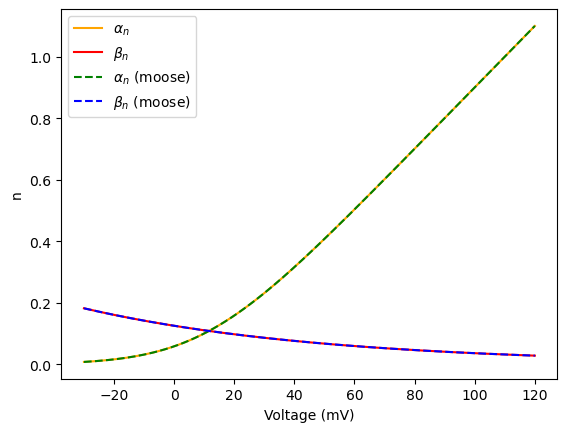

In [9]:
# Compute the values by HH formula
v = np.linspace(vmin, vmax, vdivs)
alpha_n = 0.01 * (10 - v) / (np.exp((10 - v)/10) - 1)
beta_n = 0.125 * np.exp(-v/80)

plt.plot(v, alpha_n, color='orange', label=r'$\alpha_{n}$')
plt.plot(v, beta_n, color='red', label=r'$\beta_{n}$')

#print(moose.showfields(gate))
alpha_moose = gate.tableA
beta_moose = gate.tableB - gate.tableA
v = np.linspace(gate.min, gate.max, len(alpha_moose))
plt.plot(v, alpha_moose, '--', color='green', label=r'$\alpha_{n}$ (moose)')
plt.plot(v, beta_moose,  '--', color='blue', label=r'$\beta_{n}$ (moose)')
plt.xlabel('Voltage (mV)')
plt.ylabel('n')
plt.legend()

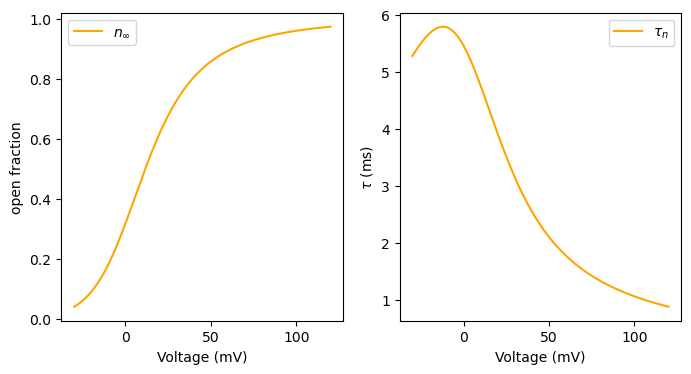

In [10]:
#print(moose.showfields(gate))
plt.subplot(121)
plt.plot(v, alpha_moose/gate.tableB, '-', color='orange', label=r'$n_{\infty}$')
plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel('open fraction')

plt.subplot(122)
plt.plot(v, 1/gate.tableB,  '-', color='orange', label=r'$\tau_{n}$')
plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel(r'$\tau$ (ms)')
plt.gcf().set_size_inches(8, 4)

## Create the voltage clamp setup
Now we can reuse our code for setting up voltage clamp 

In [11]:
###################################################
# Do not touch this code
###################################################
def create_voltage_clamp(modelpath, datapath, compartment):
    """Creates a voltage clamp object under `modelpath` and 
    a table under `datapath` to record the command voltage.
    
    Returns the `moose.PulseGen` that gives the command value 
    to the voltage clamp.
    """
    path = f'{modelpath}/elec'  # create a separate container for electronics
    
    if moose.exists(path):   # avoid duplicate connect
        print(f'{path}: Object already exists')
        vclamp = moose.VClamp(f'{path}/vclamp')
        command = moose.PulseGen(f'{path}/command')
        command_tab = moose.Table(f'{datapath}/command')
        return vclamp, command, command_tab
    elec = moose.Neutral(path)    
    vclamp = moose.VClamp(f'{path}/vclamp')
    # The voltage clamp's output is `currentOut` which will be 
    # injected into the compartment
    moose.connect(vclamp, 'currentOut', compartment, 'injectMsg')
    # The voltage clamp object senses the voltage of the compartment
    moose.connect(compartment, 'VmOut', vclamp, 'sensedIn')
    command = moose.PulseGen(f'{path}/command')

    # Connect the output of the command pulse to the command input of the voltage clamp circuit
    moose.connect(command, 'output', vclamp, 'commandIn')

    # Also setup a table to record the command voltage of the VClamp directly
    command_tab = moose.Table(f'{datapath}/command')
    moose.connect(command_tab, 'requestOut', command, 'getOutputValue')
    
    # compartment.dt is the integration time step for the compartment 
    # `tau` is the time constant of the RC filter in the circuit.
    # 5 times the integration timestep value is a good starting point for tau
    vclamp.tau = 5 * compartment.dt
    # `gain` is the proportional gain of the PID controller. `Cm/dt` is a good value
    vclamp.gain = compartment.Cm / compartment.dt

    # `ti` is the integral time of the PID controller, `dt` is a good value
    vclamp.ti = compartment.dt
    # `td` is the derivative time of the PID controller. We can set it to 0
    
    return vclamp, command, command_tab


def set_command_timecourse(command, base, delay, level):
    """Set up an existing pulse generator `command` to output `base` as initial value 
    and `level` after `delay` time"""
    command.baseLevel = base   
    command.firstDelay = delay   
    command.secondDelay = 1e9    # Never stop 
    command.firstWidth = 1e9     # Never stop
    command.firstLevel = level  

In [12]:
# Insert voltage clamp circuitry
vclamp, command, command_tab = create_voltage_clamp(model.path, data.path, axon)
# baseline is set to equilibrium potential
# delay is 10 ms, start the voltage change at this time
# command level is -60 mV, which is 10 mV above equilibrium potential
set_command_timecourse(command, 0.0, 10.0, 10.0)

## Set the passive properties of the compartment
Hodgkin and Huxley measured the voltages with respect to the resting membrane potential in teh squid axon. Following that we set the `Em` and `initVm` fields of the compartment to 0. 
The specific capacitance of a cell membrane is $1 \mu F/cm^{2}$. We can keep the same value assuming unit surface area of our compartment. As long as all units are consistent, the results should be the same.

The leak conductivity was $0.3 mS/cm^{2}$, and we set the membrane resistance as the inverse of that, which would have a unit of $k \Omega cm^2$. These are physiological units, and under this the unit of time constant would be: $\mu F/cm^{2} * k \Omega cm^2$ = $\mu F * k \Omega$ = $10^{-6} F * 10^{3} \Omega$ = $10^{-3} F \Omega$ = $10^{-3} s$ = $ms$.

In [13]:
axon.Em = 0    # Hodgkin and Huxley used resting voltage as 0
axon.initVm = 0
axon.Cm = 1
axon.Rm = 1 / 0.3   # G_leak is 0.3 mS/cm^2

## Set up data recording
We should also setup tables to record membrane current as well as K+ conductance 

In [14]:
gK_tab = moose.Table(f'{data.path}/gK')
moose.connect(gK_tab, 'requestOut', kchan, 'getGk')
im_tab = moose.Table(f'{data.path}/Im')
moose.connect(im_tab, 'requestOut', axon, 'getIm')

<moose.SingleMsg id=5 dataIndex=6 path=/Msgs[0]/singleMsg[6]>

## Setup scheduling (optional), initialize the model, and run the simulation

To work around an issue in moose (this is fixed in github repo as of March 2024), we need to explicitly schedule in what order various objects are updated during the simulation. This is done via the `setClock` and `useClock` functions.

`useClock(n, path)` schedules object(s) in path `path` on clock number `n`. That means every time clock # `n` ticks, some functions to update the state of the object at `path` get called.

`setClock(n, dt)` sets the tick interval (in simulated time) of clock number `n` to `dt`. This may also be used as the timestep for temporal integration when updating the object involves solving a differential equation.



In [15]:
## Uncomment below if you see an initial voltage transient when repeating the simulation

# simdt = 1e-5   # simulation timestep
# plotdt = 1e-3  # data collection timestep

# moose.setClock(0, simdt)
# moose.setClock(1, simdt)
# moose.setClock(2, simdt)
# moose.setClock(3, plotdt)

# # moose uses `#` character as a wildcard. 
# # "/model/#" gets all objects that are children of `/model`.
# # "/model/#[TYPE=Compartment]" gets all `Compartment` instances that are children of `/model`.
# # "/model/##" gets all objects that are descendants (children, grand children, ...) of `/model`.

# moose.useClock(0, f'{model.path}/#[TYPE=Compartment]', 'init')
# moose.useClock(1, f'{model.path}/elec/##', 'process')
# moose.useClock(1, f'{model.path}/#[TYPE=Compartment]', 'process')
# moose.useClock(2, f'{axon.path}/#[TYPE=HHChannel]', 'process')
# moose.useClock(3, f'{data.path}/#[TYPE=Table]', 'process')


Now run the simulation

In [16]:
runtime = 50
# `reinit` initialize the simulation 
moose.reinit()
# run the simulation for `runtime` duration
moose.start(runtime)

## Plot the results

Text(0.5, 0, 'Time (ms)')

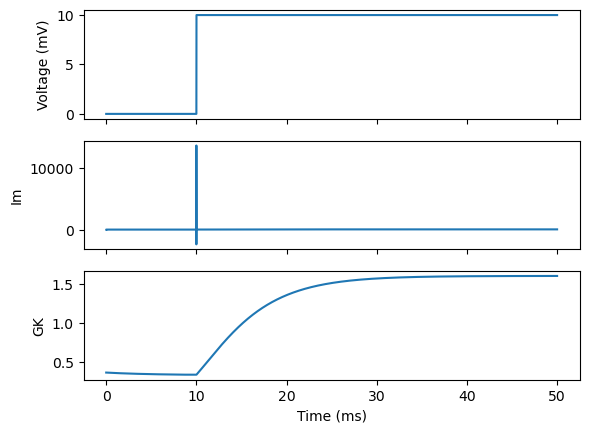

In [17]:
v_command = command_tab.vector
t_command = np.arange(len(v_command)) * command_tab.dt
fig, axes = plt.subplots(nrows=3, ncols=1, sharex='all')
axes[0].plot(t_command, v_command, label='Command voltage')
axes[0].set_ylabel('Voltage (mV)')

im = im_tab.vector
t_im = np.arange(len(im)) * im_tab.dt
axes[1].plot(t_im, im, label='Membrane current (mA/cm^2)')
axes[1].set_ylabel('Im')
#plt.plot(t_v, v_end, ':', label='Voltage at last compartment')
gK = gK_tab.vector
t_gK = np.arange(len(gK)) * gK_tab.dt
axes[2].plot(t_gK, gK)
axes[2].set_ylabel('GK')
axes[2].set_xlabel('Time (ms)')

## Note on debugging
Two common source of bug in moose model setup are
1. forgetting to connect the fields for messaging, or connecting the incorrect fields. The connections (messages) to and from a moose object can be displayed with the `showmsg` function.

In [18]:
moose.showmsg(kchan.path)

INCOMING:
  /sim[0]/model[0]/axon[0]/K[0], [parentMsg] <-- /sim[0]/model[0]/axon[0], [childOut]
  /sim[0]/model[0]/axon[0]/K[0], [process,reinit] <-- /clock[0], [process4,reinit4]
  /sim[0]/model[0]/axon[0]/K[0], [getGk] <-- /sim[0]/data[0]/gK[0], [requestOut]

OUTGOING:
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateX[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateY[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [childOut] --> /sim[0]/model[0]/axon[0]/K[0]/gateZ[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/K[0], [channelOut] --> /sim[0]/model[0]/axon[0], [handleChannel]



2. Forgetting to initialize a field that needs to be initialized (e.g. `Gbar` of the channel object, not `Gk`). The field values can be checked with the `showfields` function.

In [19]:
moose.showfields(kchan)


[/sim[0]/model[0]/axon[0]/K[0]]
name                 = K
className            = HHChannel
tick                 = 4
dt                   = 5e-05
Ek                   = -12.0
Gbar                 = 36.0
Gk                   = 1.6088558556642112
Ik                   = -35.39482882460292
X                    = 0.45978379300996514
Xpower               = 4.0
Y                    = 0.0
Ypower               = 0.0
Z                    = 0.0
Zpower               = 0.0
instant              = 0
modulation           = 1.0
useConcentration     = 0



## Simulate Hodgkin and Huxleys experiment with different voltage steps
Hodgkin and Huxley first identified the properties of the $K^{+}$ conductance by stepping the command voltage to various values (6, 10, 19, 26, 32, 38, 51, 63, 76, 88, 100, 109 mV above resting value). To do this we can repeat the simulation by changing the command voltage in our voltage clamp, and accumulating the time series of GK. We already defined the function `set_command_time_course(command, base, delay, level)` which we can use in a loop to update the level and rerun the simulation.

Text(0, 0.5, 'Conductivity (mS/cm^2)')

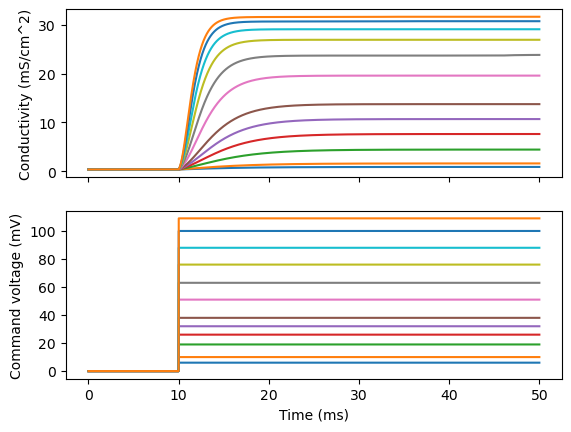

In [20]:
commands = np.r_[6, 10, 19, 26, 32, 38, 51, 63, 76, 88, 100, 109]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='all')

for level in commands:
    set_command_timecourse(command, 0.0, 10.0, level)
    moose.reinit()
    moose.start(runtime)
    gK = gK_tab.vector
    t_gK = np.arange(len(gK)) * gK_tab.dt
    axes[0].plot(t_gK, gK, label=f'{level} mV')
    v_command = command_tab.vector
    t_command = np.arange(len(v_command)) * command_tab.dt
    axes[1].plot(t_command, v_command)


axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Command voltage (mV)')
axes[0].set_ylabel('Conductivity (mS/cm^2)')

## Exercises
1. Collect the final steady state values of the $K^{+}$ conductance (`Gk`) and plot against the command voltage.